In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter, CustomDiscreteParameter, CategoricalParameter
from baybe.objectives import SingleTargetObjective
from baybe.targets import NumericalTarget
from baybe.searchspace import SearchSpace
from baybe.surrogates import GaussianProcessSurrogate

from baybe.utils.random import set_random_seed


from baybe import Campaign
from baybe.recommenders import (
    BotorchRecommender,
    RandomRecommender,
    TwoPhaseMetaRecommender,
)
from baybe.simulation import simulate_scenarios

from base.utils import custom_fingerprinter, custom_PCA_fingerprinter, custom_PCA_from_substance
from base.pretrained_repr import PretrainedWrapper, ChemBERTa_Fingerprint, CheMeleonFingerprint, LLM_Fingerprint
from base.utils import _normalize
from base.kernels import AdaptiveKernelFactory


sseed = 142


In [2]:
lookup = pd.read_excel("shields_dataset.xlsx")

# not needed, BayBE normalizes automatically
lookup["Temp_C"] = _normalize(lookup["Temp_C"]) 
lookup["Concentration"] = _normalize(lookup["Concentration"]) 

F_BEST = lookup['yield'].max()
lookup.head()


,entry,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield,Base,Ligand,Solvent
0,0,O=C([O-])C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC(N(C)C)=O,0.447917,0.5,5.47,Potassium acetate,BrettPhos,DMAc
1,1,O=C([O-])C.[K+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.447917,0.5,0.00,Potassium acetate,Di-tert-butylphenylphosphine,DMAc
2,2,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CC(N(C)C)=O,0.447917,0.5,78.95,Potassium acetate,(t-Bu)PhCPhos,DMAc
3,3,O=C([O-])C.[K+],P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,CC(N(C)C)=O,0.447917,0.5,7.26,Potassium acetate,Tricyclohexylphosphine,DMAc
4,4,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC(N(C)C)=O,0.447917,0.5,28.15,Potassium acetate,PPh3,DMAc


In [3]:
# helpers for plotting results

PLOTARGS = {
    'linestyle': 'solid',
    'marker': 'o',
    'markersize': 6,
    'markeredgecolor': 'none'
}
FIGSIZE = (11,6)

def plot_campaign(results):
    results.rename(columns = {"Scenario": "Campaign Name"}, inplace = True)
    sns.lineplot(data = results,
             x = "Num_Experiments",
             y = "yield_CumBest",
             hue = "Campaign Name",
             **PLOTARGS)

    plt.axhline(y = F_BEST, color = 'red', linestyle = '--', label = 'Best Possible')
    plt.gcf().set_size_inches(FIGSIZE)
    plt.gca().set_ylim(plt.gca().get_ylim()[0], F_BEST+5)
    plt.title('Tutorial Campaign');

In [4]:
# extact searchspace columns

solvent_data = dict(sorted(set(zip(lookup.Solvent, lookup.Solvent_SMILES))))
base_data = dict(sorted(set(zip(lookup.Base, lookup.Base_SMILES))))
ligand_data = dict(sorted(set(zip( lookup.Ligand, lookup.Ligand_SMILES))))

temperature_values = set(lookup.Temp_C)
concentration_values = set(lookup.Concentration)

In [5]:
# Discrete numerical parameters
# Check if they are normalized properly by default
p_temp = NumericalDiscreteParameter(name = "Temp_C", values = temperature_values)
p_concentration = NumericalDiscreteParameter(name = "Concentration", values = concentration_values)

objective = SingleTargetObjective(target=NumericalTarget(name="yield", mode="MAX"))


MC_RUNS = 10 # this will take fairly long on typical free-of-charge cloud compute
NUMBER_ITERATIONS = 26
BATCH_SIZE = 1
SWITCH_AFTER = 9

In [ ]:
# get HSFs

#fingerprinter = PretrainedWrapper(LLM_Fingerprint, model_name='GT4SD/multitask-text-and-chemistry-t5-base-augm', pooling_method='average', normalize_embeddings=False)
#fingerprinter = PretrainedWrapper(CheMeleonFingerprint)
fingerprinter = PretrainedWrapper(ChemBERTa_Fingerprint, variant='zinc-base-v1')

p_solvent_t5_base = CustomDiscreteParameter(
                                        name="Solvent",
                                        data=custom_PCA_fingerprinter(solvent_data, fingerprinter, target_variance=0.98, norm="global"),
                                        decorrelate=False,)


p_base_t5_base = CustomDiscreteParameter(
                                        name="Base",
                                        data=custom_PCA_fingerprinter(base_data, fingerprinter, target_variance=0.98, norm="global"),
                                        decorrelate=False,)

p_ligand_t5_base = CustomDiscreteParameter(
                                        name="Ligand",
                                        data=custom_PCA_fingerprinter(ligand_data, fingerprinter, target_variance=0.98, norm="global"),
                                        decorrelate=False,)




Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
p_solvent_t5_base.data.shape, p_base_t5_base.data.shape, p_ligand_t5_base.data.shape, 

((4, 3), (4, 2), (12, 6))

In [8]:
chemeleon_parameters = [
    p_solvent_t5_base,
    p_base_t5_base,
    p_ligand_t5_base,
    p_concentration,
    p_temp
]

searchspace = SearchSpace.from_product(parameters=chemeleon_parameters)


feat_dim = len(searchspace.comp_rep_columns)
feat_dim

13

In [ ]:
# Create adaptive surrogates
surrogate = GaussianProcessSurrogate(
    kernel_or_factory= AdaptiveKernelFactory()
)

set_random_seed(sseed)
# Use TwoPhaseMetaRecommender to handle empty training data
campaign = Campaign(
    searchspace=searchspace,
    objective=objective,
    recommender=TwoPhaseMetaRecommender(
        initial_recommender=RandomRecommender(),
        recommender=BotorchRecommender(
            surrogate_model=surrogate,
            # log more robust than simple EI
            acquisition_function="qLogExpectedImprovement"
        ),
        switch_after=SWITCH_AFTER
    )
)

In [10]:
# Run the utility for backtesting
results = simulate_scenarios(
    {'TUTORIAL': campaign},
    lookup, # the initial dataframe with the experimental results is our lookup
    batch_size = BATCH_SIZE, # how many experiments to perform in one batch
    n_doe_iterations = NUMBER_ITERATIONS, # how many batches to select successively
    n_mc_iterations = MC_RUNS, # number of Monte Carlo iterations -> this corresponds to the number of times we take a new random starting point
                                # and run the full campaign from scratch (to get a statistically) meaningful sense about the merit of the featurization approach
)
results.head()

100%|##########| 10/10 [00:28<00:00,  2.89s/it]


,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,yield_Measurements,yield_IterBest,yield_CumBest
0,TUTORIAL,0,0,1,[0.0],0.00,0.00
1,TUTORIAL,0,1,2,[0.0],0.00,0.00
2,TUTORIAL,0,2,3,[40.47],40.47,40.47
3,TUTORIAL,0,3,4,[0.0],0.00,40.47
4,TUTORIAL,0,4,5,[20.2],20.20,40.47


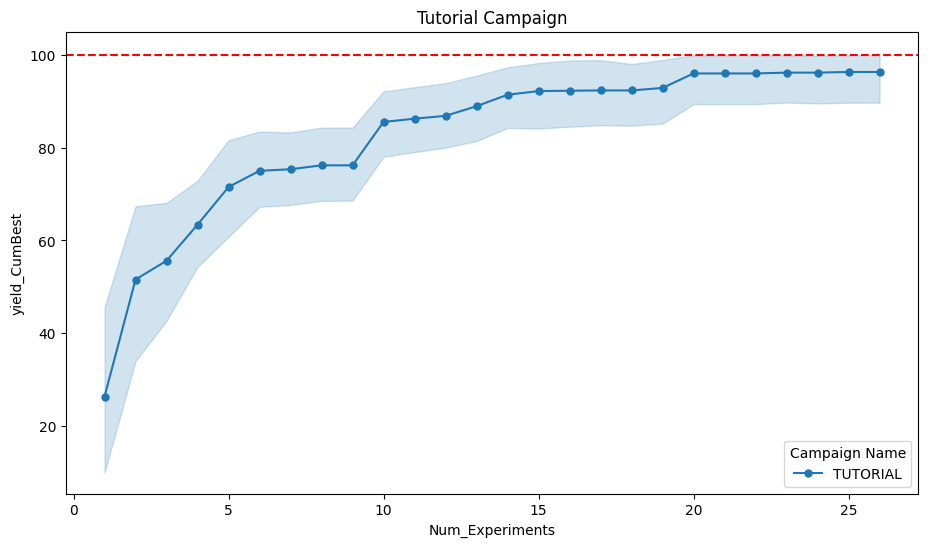

In [11]:
plot_campaign(results)